# ***Digit Localization & Classification: MNIST Dataset***

## *Import Libraries*

In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import PIL, os, re, time, json
import matplotlib.pyplot as plt
import seaborn
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Input
import PIL.Image, PIL.ImageFont, PIL.ImageDraw


%matplotlib inline

## *Visualization Functions: Draw bounding boxes around MNIST Numbers*
#### We are preparing a synthsized dataset from MNIST dataset where we are arranging the numbers on a 75 x 75 canvas; to further practice the bounding box technique.

In [2]:
image_width = 75
image_height = 75
use_normalized_coordinates = True

# Function 1
# Bounding Box on Image Array
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    '''image: Numpy array object
       Boxes: 2D numpy array of [N,4]: (ymin, xmin, ymax, xmax) -- Coordinates are normalized [0,1]
       color: Color of bounding box (default: red)
       thickness: line thickness (default: 4)
       display_str_list: List of strings for each bounding box   '''
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new(mode="RGBA", size=image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)

# Function 2
def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=1, display_str_list=()):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return 
    if (len(boxes_shape) != 2 or boxes_shape[1] != 4):
        raise ValueError('Input must be of format [N,4]')
    
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],boxes[i,2], color[i], thickness, display_str_list[i])

# Function 3
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color='red', thickness=1, display_str = None, use_normalized_coordinates=True):
    '''Bounding Box coordinates can be mentioned in absolute(pixels) or 
    normalized coordinates by setting the use_normalized_coordinates argument
    Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.'''
    
    draw = PIL.ImageDraw.Draw(image)
    image_width, image_height = image.size
    if (use_normalized_coordinates):
        (left, right, top, bottom) = (xmin*image_width, xmax*image_width,
                                     ymin*image_height, ymax*image_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)    
    # Draw the bounding box like starting from one end and coming a full round to the same end: ALl the coordinates on the path need ot be mentioned in the list
    draw.line([(left, top),(left, bottom), (right, bottom), (right, top), (left, top)], width= thickness, fill=color)

## *Visualize the data with boxes and predictions*

In [3]:
# Matplotlib configuration
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# Create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels

def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    n = 10
    indexes = np.random.choice(len(predictions), size= n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]
    
#     pred_bboxes: Bounding boxes as predicted by the model
#     bboxes: Labels of bounding boxes
    n_iou = []
    if (len(iou)>0):
        n_iou = iou[indexes]
    if (len(pred_bboxes) > 0):
        n_pred_bboxes = pred_bboxes[indexes,:]  
    if (len(bboxes)>0):
        n_bboxes = bboxes[indexes,:]
    
    n_digits = n_digits*255.0
    print(n_digits.shape)
    n_digits = n_digits.reshape(n,75,75)
    fig = plt.figure(figsize=(20,4))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
    # Loop to show the bounding boxes on images
    for i in range(n):
        ax = fig.add_subplot(1, 10,i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i]) 
        
        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])
        
        # Creating the image to be shown with bounding boxes
        img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=['true', 'pred'])
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])
        
        if (n_predictions[i] != n_labels[i]):
            ax.xaxis.label.set_color('red')
        
        plt.imshow(img_to_draw)
        if (len(iou) > i):
            color="black"
            if (n_iou[i][0] < iou_threshold):
                color="red"
            ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)

## *Understanding numpy.array and constructing bounding boxes around a face*

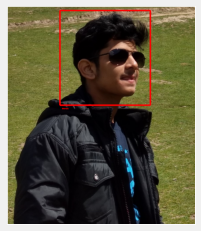

In [4]:
pil_img = PIL.Image.open("portrait1.jpg")
draw = PIL.ImageDraw.Draw(pil_img)
draw.line([(240,20), (240,450),(650,450),(650,20),(240,20)], width =7, fill="red")
# font = PIL.ImageFont.truetype(r'C:\WINDOWS\FONTS\BAHNSCHRIFT.TTF',size= 50)
draw.text((250,460), text="Human" ,fill="red", align="right")
test_img = np.asarray(pil_img)
plt.xticks([])
plt.yticks([])
plt.imshow(test_img)
plt.show()
plt.imsave("Linked_portrait.jpg", test_img)

## *Loading & Preprocessing Dataset*

- `read_image_tfds`: randomly overlays the "digit" image on top of a larger canvas.
- `get_training_dataset`: loads data and splits it to get the training set.
- `get_validation_dataset`: loads and splits the data to get the validation set.

In [5]:
# Transform the number images in dataset by pasting it on a 75 x 75 canvas at random locations

def read_image_tfds(image, label):
    xmin = tf.random.uniform((), minval=0, maxval=48, dtype=tf.int32)
    ymin = tf.random.uniform((), minval=0, maxval=48, dtype=tf.int32)
    print("Read_Image_tfds:  Initial Image shape: ",image.shape)
    image = tf.reshape(image, (28, 28, 1))
    # Padding takes place here 
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    # Typecasting to float32 and normalization
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    
    xmax = (xmin + 28)/75
    ymax = (ymin + 28)/75
    xmin = xmin/75
    ymin = ymin/75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

# Loads and maps the training split of the dataset using the map function.
def get_training_dataset():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(64, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset

# Loads and maps the validation split of the dataset using the map function.
def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset
    
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

Read_Image_tfds:  Initial Image shape:  (28, 28, 1)
Read_Image_tfds:  Initial Image shape:  (28, 28, 1)


## *Visualize Data*

(10, 75, 75, 1)
(10, 75, 75, 1)


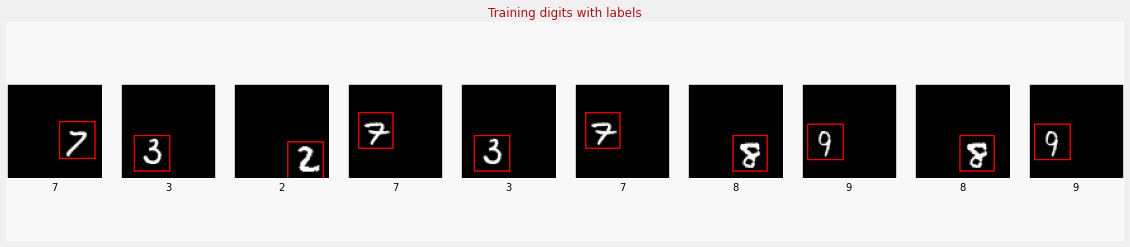

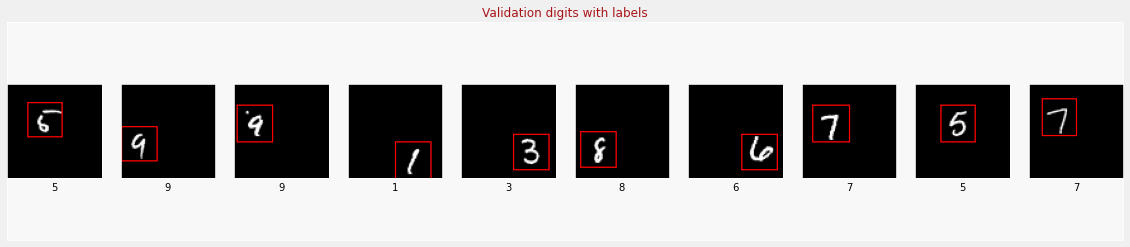

In [6]:
(training_digits, training_labels, training_bboxes,
validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "Training digits with labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), "Validation digits with labels")

## *Model creation*

In [7]:
inputs = Input(shape= (75, 75, 1))
x = Conv2D(16, (3,3), activation='relu', input_shape = (75,75,1))(inputs)
x = AveragePooling2D((2,2))(x)

x = Conv2D(32, 3, activation='relu')(x)
x = AveragePooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = AveragePooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

classification_output = Dense(10, activation='softmax', name="Classification_Output")(x)
bounding_boxes_preds = Dense(4, name="Bounding_Box_Predictions")(x)

model = Model(inputs=inputs, outputs = [classification_output, bounding_boxes_preds])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 73, 73, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 36, 36, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 34, 34, 32)   4640        average_pooling2d[0][0]          
______________________________________________________________________________________________

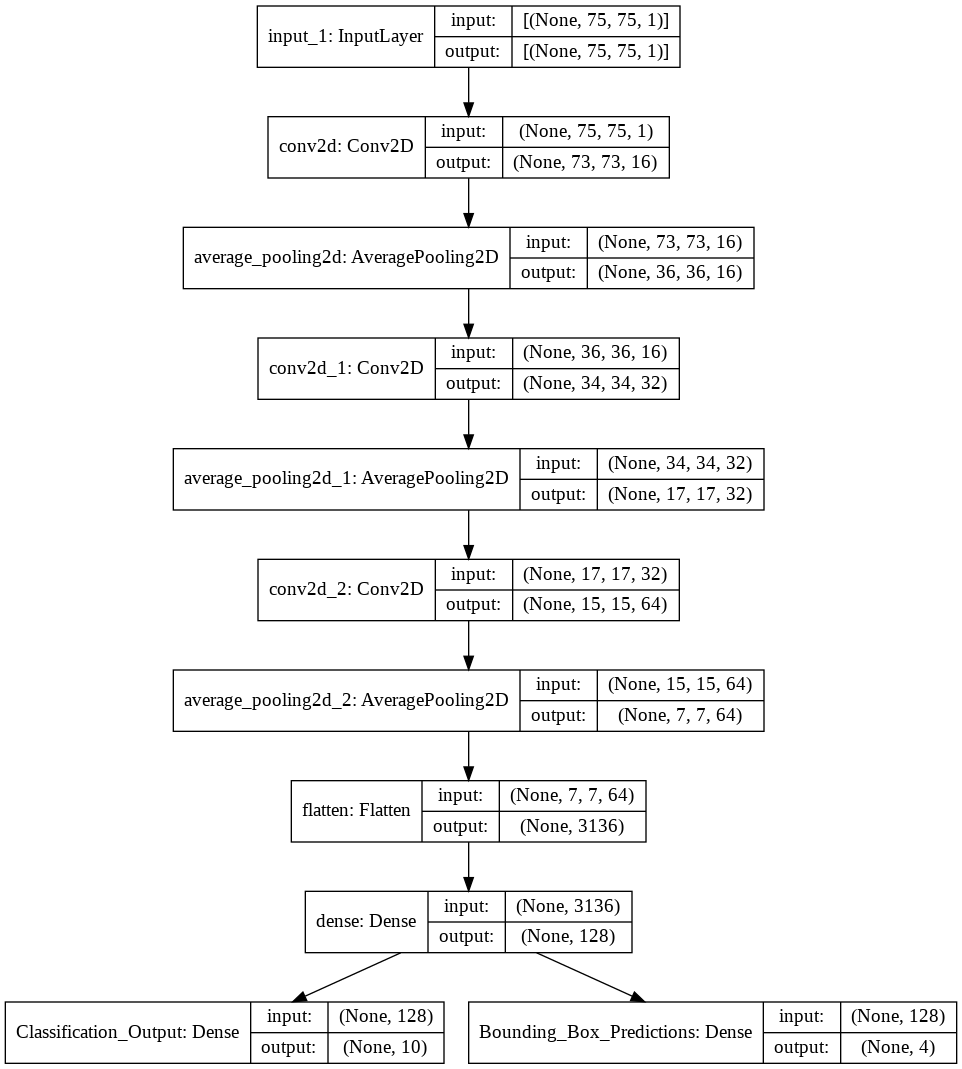

In [8]:
keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

## *Compile and Train model*

In [9]:
# Compile model

model.compile(optimizer='adam', loss={"Classification_Output": 'categorical_crossentropy',
                                      "Bounding_Box_Predictions": 'mse'}, 
                                metrics = {"Classification_Output": 'accuracy',
                                           "Bounding_Box_Predictions": 'mse'})

In [10]:
# Train the model

history = model.fit(training_dataset,
                    steps_per_epoch=60000//64,
                    epochs= 10,
                    validation_data= validation_dataset,
                    validation_steps=1)

Epoch 1/10
937/937 [==============================] - 20s 19ms/step - loss: 0.9131 - Classification_Output_loss: 0.8980 - Bounding_Box_Predictions_loss: 0.0151 - Classification_Output_accuracy: 0.6915 - Bounding_Box_Predictions_mse: 0.0151 - val_loss: 0.3317 - val_Classification_Output_loss: 0.3219 - val_Bounding_Box_Predictions_loss: 0.0098 - val_Classification_Output_accuracy: 0.9036 - val_Bounding_Box_Predictions_mse: 0.0098
Epoch 2/10
937/937 [==============================] - 12s 13ms/step - loss: 0.2549 - Classification_Output_loss: 0.2487 - Bounding_Box_Predictions_loss: 0.0062 - Classification_Output_accuracy: 0.9244 - Bounding_Box_Predictions_mse: 0.0062 - val_loss: 0.1808 - val_Classification_Output_loss: 0.1762 - val_Bounding_Box_Predictions_loss: 0.0045 - val_Classification_Output_accuracy: 0.9461 - val_Bounding_Box_Predictions_mse: 0.0045
Epoch 3/10
937/937 [==============================] - 12s 13ms/step - loss: 0.1821 - Classification_Output_loss: 0.1784 - Bounding_Box_P

## *Testing*

In [11]:
loss, Classification_Output_loss, Bounding_Box_Predictions_loss, Classification_Output_accuracy, Bounding_Box_Predictions_mse = model.evaluate(validation_dataset, steps=1)
print("Accuracy: ", Classification_Output_accuracy*100,"%")

1/1 [==============================] - 1s 1s/step - loss: 0.0588 - Classification_Output_loss: 0.0578 - Bounding_Box_Predictions_loss: 0.0010 - Classification_Output_accuracy: 0.9812 - Bounding_Box_Predictions_mse: 0.0010
Accuracy:  98.11999797821045 %


## *Individual Accuracy Plot*

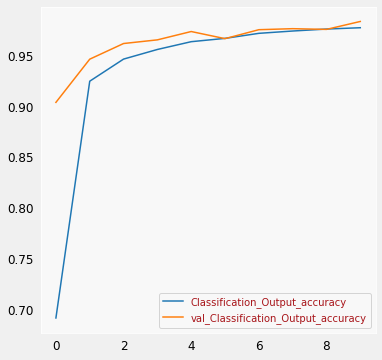

In [21]:
df = pd.DataFrame(history.history)
plt.figure(figsize=(6,6))
plt.plot(df[["Classification_Output_accuracy", "val_Classification_Output_accuracy"]])
plt.legend(["Classification_Output_accuracy", "val_Classification_Output_accuracy"])
plt.show()

## *All-In-One plot*

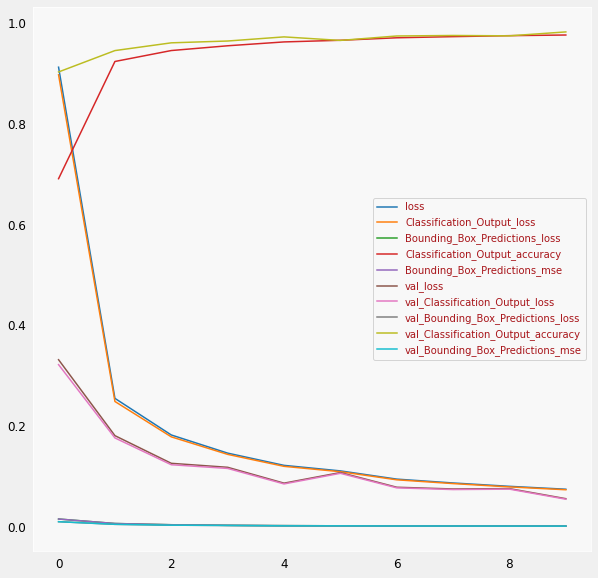

In [22]:
df = pd.DataFrame(history.history)
plt.figure(figsize=(10,10))
plt.plot(df)
plt.legend(df.columns)
plt.show()

## *Intersection-Over-Union(iou)*

In [23]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    # Actual Logic for intersection
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

## *Visualize model predictions & actual labels*

Number of predictions where iou > threshold(0.6): 9301
Number of predictions where iou < threshold(0.6): 699
(10, 75, 75, 1)


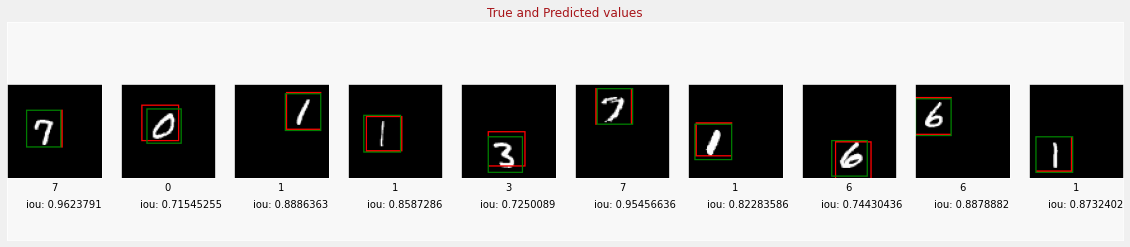

In [24]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

#### **The Red boxes represent the predicted bounding boxes & Green boxes represent the actual bounding boxes**